In [1]:
using Luxor
using Colors
using Plots
using IterTools
using DataFrames
using OpenStreetMapX
using LightOSM
using KernelDensity
using Parsers
using Downloads
using OSMToolset
include("../kernel_density.jl")
include("../distance.jl")
include("../prepare_data.jl")
include("../analyse.jl")
include("../plots.jl")
include("../transform.jl")
include("../tile_regression.jl")
include("../kernel_density.jl")

kernel_density (generic function with 1 method)

In [2]:
city = "Kielce"
admin_level = "8"
search_area = 100
wilderness_distance = 300
shape = "rectangle"
calculate_percent = true
num_of_points = 30
distance_sectors = 200.0
#scrape_config = "poi_config_test.csv"
ncols=2
nrows=2
num_of_sectors = ncols*nrows

road_types = ["motorway", "trunk", "primary", "secondary", 
            "tertiary", "residential", "service", "living_street",
            "motorway_link", "trunk_link", "primary_link", "secondary_link", 
            "tertiary_link"]

scp_config = "poi_config_test.csv"


"poi_config_test.csv"

In [3]:

data = prepare_city_map(city, #city_name
        admin_level, #admin_level
        search_area, #search_area
        wilderness_distance, #wilderness_distance
        shape, #shap;
        distance_sectors = distance_sectors,
        rectangle_boundaries= get_city_bounds(city,admin_level),
        #calculate_percent = calculate_percent,
        #num_of_points = num_of_points,
        scrape_config = scp_config,
        in_admin_bounds=false)

┌ Info: Read map data from cache Kielce.osm.cache
└ @ OpenStreetMapX /home/adamkas/.julia/packages/OpenStreetMapX/gCd33/src/parseMap.jl:97


(Union{Nothing, ENU}[ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf) … ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf); ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf) … ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf); … ; ENU(6097.002978443719, -8748.15066875947, 0.0) ENU(6097.002978443719, -8545.97415096116, 0.0) … ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf); ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf) … ENU(Inf, Inf, Inf) ENU(Inf, Inf, Inf)], LLA(50.8719903, 20.6310488, 0.0), AttractivenessSpatIndex{AttractivenessMetaPOI, typeof(get_attractiveness_group)}(RTree{Float64, 2, SpatialElem{Float64, 2, Int64, OSMToolset.AttractivenessData{AttractivenessMetaPOI}}}(variant=RTreeStar, tight_mbrs=true, nearmin_overlap=32, fill_factor=0.7, split_factor=0.4, reinsert_factor=0.3, leaf_capacity=100, branch_capacity=100)
12153 element(s) in 3 level(s) (1, 2, 200 node(s) per level):
 level=3 nchildren=2 mbr=((-8208.14993891081, -10717.312346667542), (6853.530114672147, 5236.759859279688)), 12153×10 DataFrame
   Row │ elemtype  elemid     nodeid     

In [4]:
city_centre = data[2]
tiles = generate_tiles(city,admin_level,ncols,nrows)
tls,xs,ys = calc_all_tiles_length(city,city_centre,road_types,tiles,ncols,nrows)


(Any[201937.12535866638, 431973.7409748533, 215855.70538712223, 589431.1383599773], [-8498.156058710252 -1089.5906745512414 -1089.5906745512414 -8498.156058710252; -8487.108988301607 -1088.1711888792363 -1088.1711888792363 -8487.108988301607; -1091.0089177851844 6307.931302140612 6307.931302140612 -1091.0089177851844; -1089.5906745512414 6299.713520626413 6299.713520626413 -1089.5906745512414], [-8748.15066875947 -8748.15066875947 -1980.536833086564 -1980.536833086564; -1973.7262482568517 -1973.7262482568517 4793.969772889885 4793.969772889885; -8754.970118446648 -8754.970118446648 -1976.8257475595692 -1976.8257475595692; -1980.536833086564 -1980.536833086564 4797.676023727296 4797.676023727296])

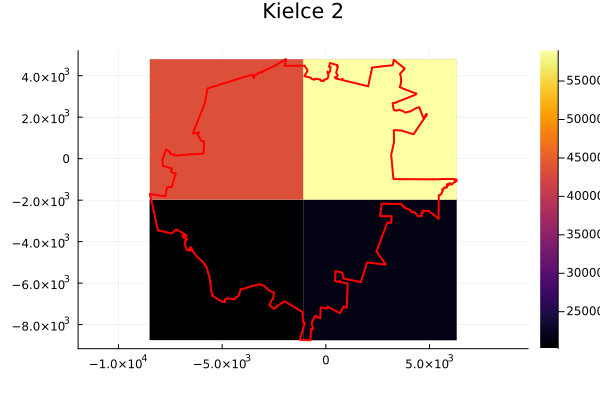

In [8]:
tile_plot(data[5],tls,xs,ys,string(city," ",2))

In [9]:

dim1, dim2 = size(xs)

LLA_matrix = [ENU(0.0,0.0,0.0) for _ in 1:dim1, _ in 1:dim2]
for i in 1:dim1
    for j in 1:dim2
        LLA_matrix[i,j] = ENU(xs[i,j],ys[i,j],0.0)
    end
end

south_lat = []
north_lat = []
west_lng = []
east_lng = []

for pol in 1:dim1
    push!(south_lat, minimum([i.north for i in LLA_matrix[pol,:]]))
    push!(north_lat, maximum([i.north for i in LLA_matrix[pol,:]]))
    push!(west_lng, minimum([i.east for i in LLA_matrix[pol,:]]))
    push!(east_lng, maximum([i.east for i in LLA_matrix[pol,:]]))
end

LLA_coords = DataFrame(
    south_lat = south_lat,
    north_lat = north_lat,
    west_lng = west_lng,
    east_lng = east_lng    
)

CSV.write(string("spatial_data/ENU_coords.csv"),LLA_coords)

"spatial_data/ENU_coords.csv"

In [10]:
LLA_coords

Row,south_lat,north_lat,west_lng,east_lng
,Any,Any,Any,Any
1,-10476.7,-8719.16,-10375.6,-7323.35
2,-8714.12,-6956.55,-10372.2,-7320.94
3,-6951.52,-5193.94,-10368.8,-7318.53
4,-5188.91,-3431.32,-10365.4,-7316.13
5,-3426.29,-1668.69,-10362.0,-7313.72
6,-1663.67,93.935,-10358.6,-7311.31
7,98.9601,1856.57,-10355.2,-7308.9
8,1861.59,3619.21,-10351.8,-7306.49
9,3624.23,5381.85,-10348.4,-7304.08
